In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pubg-games-dataset/PUBG_Game_Prediction_data.csv


# Table of content
1. [Importing library](#import)
2. [Reading data](#read)
3. [Data Wrangling](#Wranling)
4. [Feature Engineering](#feature)
5. [ML-Catboost model](#catboost)

# Importing library<a class="anchor" id="import"></a>

In [2]:
# handling warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (16, 6)

import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import catboost as cb

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [3]:
!pip install catboost

# <font color="green"> Reading Data</font><a class="anchor" id="read"></a>

In [4]:
df=pd.read_csv("/kaggle/input/pubg-games-dataset/PUBG_Game_Prediction_data.csv")
df.shape

(4446966, 29)

In [5]:
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


# <font color="green">Data Wargling<a id="Wranling">

**Check for the rows with missing win prediction value**

In [6]:
df[df["winPlacePerc"].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [7]:
# remove the data row
df.drop(2744604, inplace=True)

**Understanding the player distruction in a game**

In [8]:
# prepare new parameter to know how many players are in a game
df['playersJoined'] = df.groupby('matchId')['matchId'].transform('count')

In [9]:
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0.0000,0,0.00,0,0,244.80,1,1466,0.4444,96
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0.0045,0,11.04,0,0,1434.00,5,0,0.6400,91
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0.0000,0,0.00,0,0,161.80,2,0,0.7755,98
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0.0000,0,0.00,0,0,202.70,3,0,0.1667,91
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0.0000,0,0.00,0,0,49.75,2,0,0.1875,97


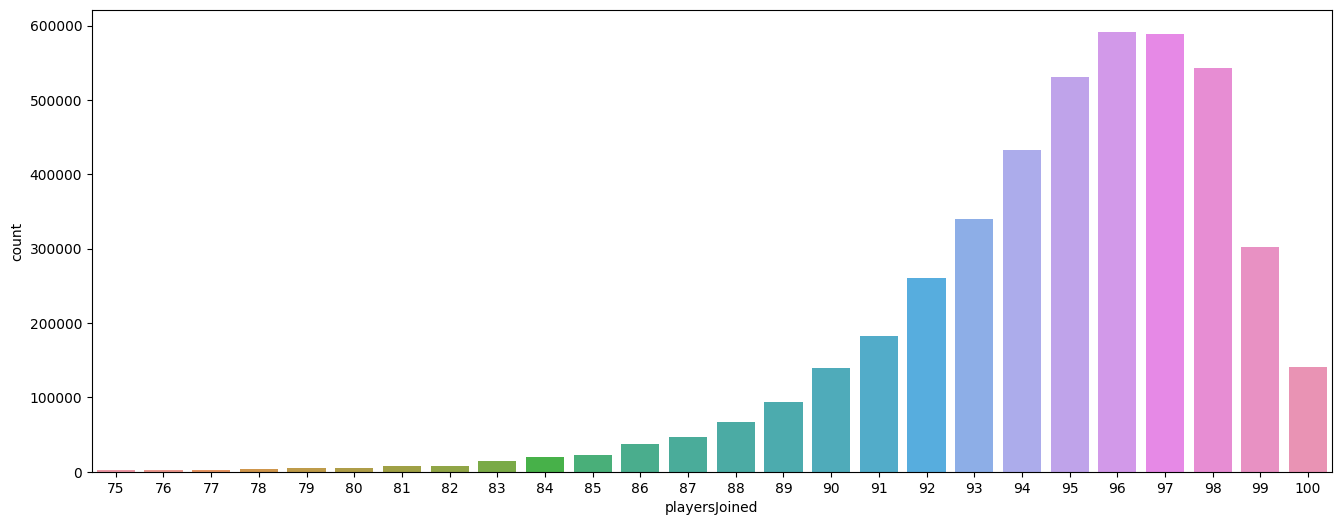

In [10]:
sns.countplot(x=df[df['playersJoined']>=75]['playersJoined'])
plt.show()

# Analysis the data

**kills without moving?**

In [11]:
# Making a new column thats has all type of distances
df['TotalDistance']=df['rideDistance']+df['walkDistance']+df['swimDistance']


#for checking anamoly detection that
# the person has not moved but still managed to do the kills
df['killsWithoutMoving']=((df['TotalDistance']==0)&(df['kills']>0))

In [12]:
df[df['killsWithoutMoving']==True].shape

(1535, 32)

In [13]:
# drop the table
df.drop(df[df['killsWithoutMoving']==True].index,inplace=True)

# Extra-ordinary Road kills

In [14]:
# more than 5 road kills is not practical case so drop that rows
df[df['roadKills']>5].shape

(46, 32)

In [15]:
df.drop(df[df['roadKills']>5].index,inplace=True)

# kills by per playeres

Text(0.5, 0, 'Number of Kills')

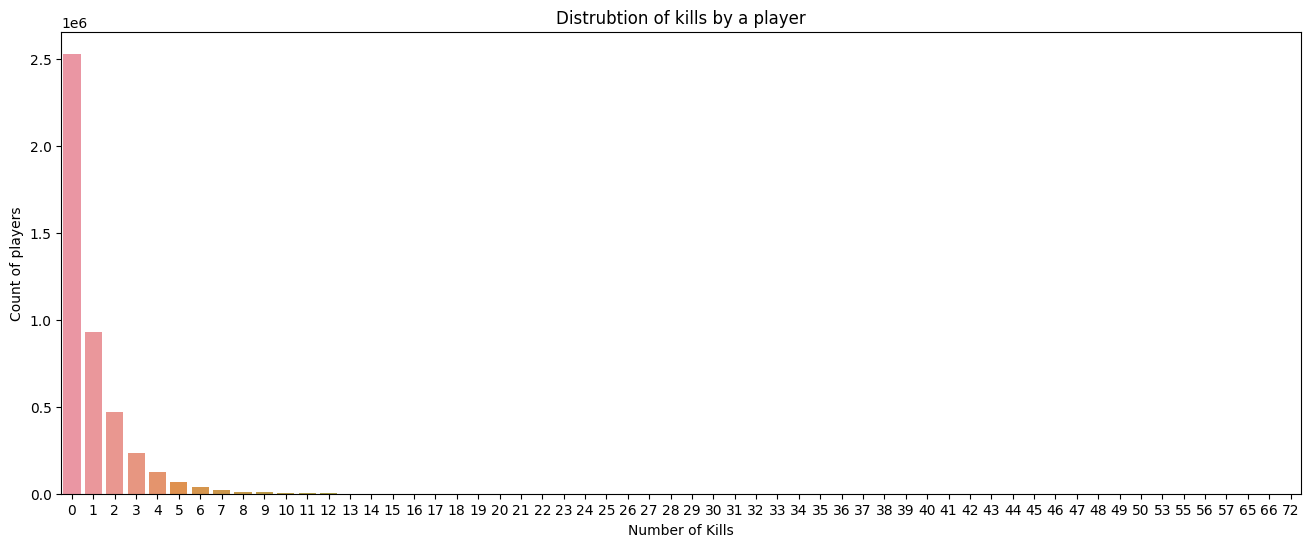

In [16]:
sns.countplot(data=df,x=df['kills']).set_title("Distrubtion of kills by a player")
plt.ylabel("Count of players")
plt.xlabel("Number of Kills")

Text(0.5, 0, 'Number of Kills')

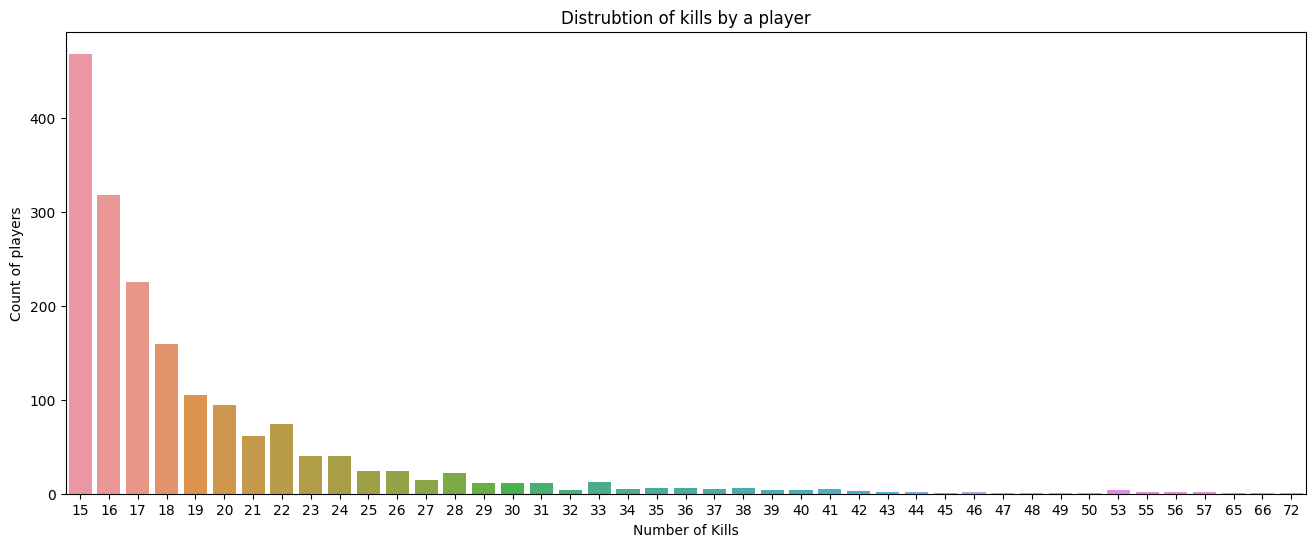

In [17]:
sns.countplot(data=df[df['kills']>=15],x='kills').set_title("Distrubtion of kills by a player")
plt.ylabel("Count of players")
plt.xlabel("Number of Kills")

In [18]:
# More than 20kills by a single player is not practical there are two chance 
# player might be pro or hacker

df[df['kills']>20].shape

(417, 32)

In [19]:
# drop the that rows
df.drop(df[df['kills']>20].index,inplace=True)

# Headshot

In [20]:
# 100% headshot rate also shows that player is hacker(if kills is more)
# create a new colums headshot rate

df['headShot_rate']=df['headshotKills']/df['kills']

# if kills is 0 then headshot rate is NA 
# so we put 0 in that place

df['headShot_rate']=df['headShot_rate'].fillna(0)

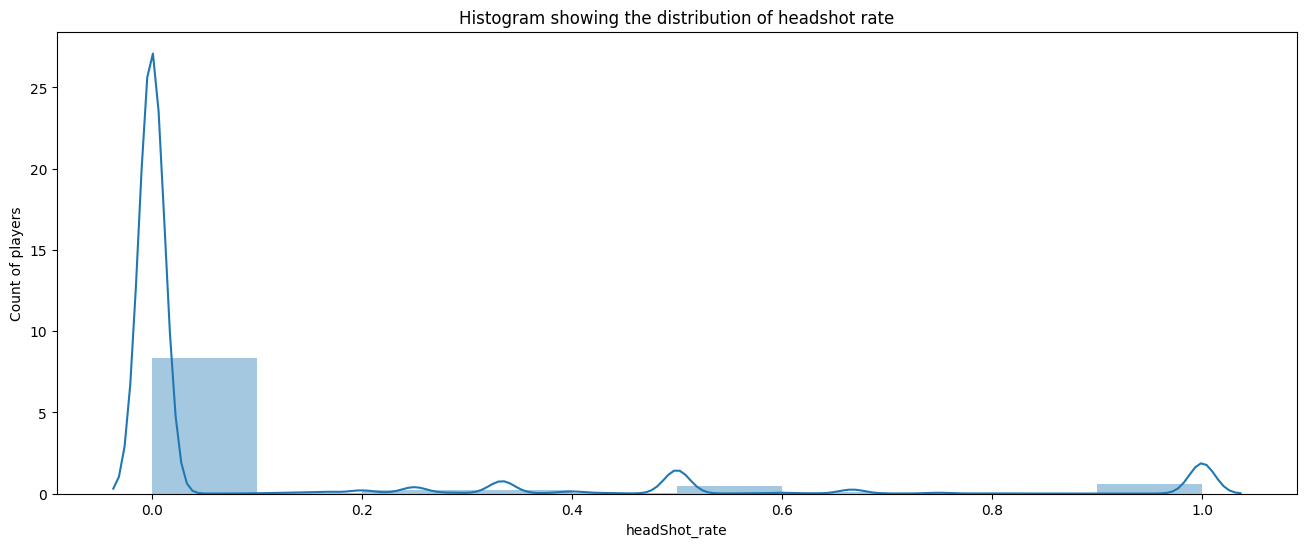

In [21]:
# plot the headshot rate distribution
sns.distplot(df['headShot_rate'], bins =10).set_title("Histogram showing the distribution of headshot rate")
plt.ylabel("Count of players")
plt.show()

In [22]:
df[(df['headShot_rate']==1)&(df['kills']>5)].shape

(187, 33)

In [23]:
df.drop(df[(df['headShot_rate']==1)&(df['kills']>6)].index,inplace=True)

# Longest shot 

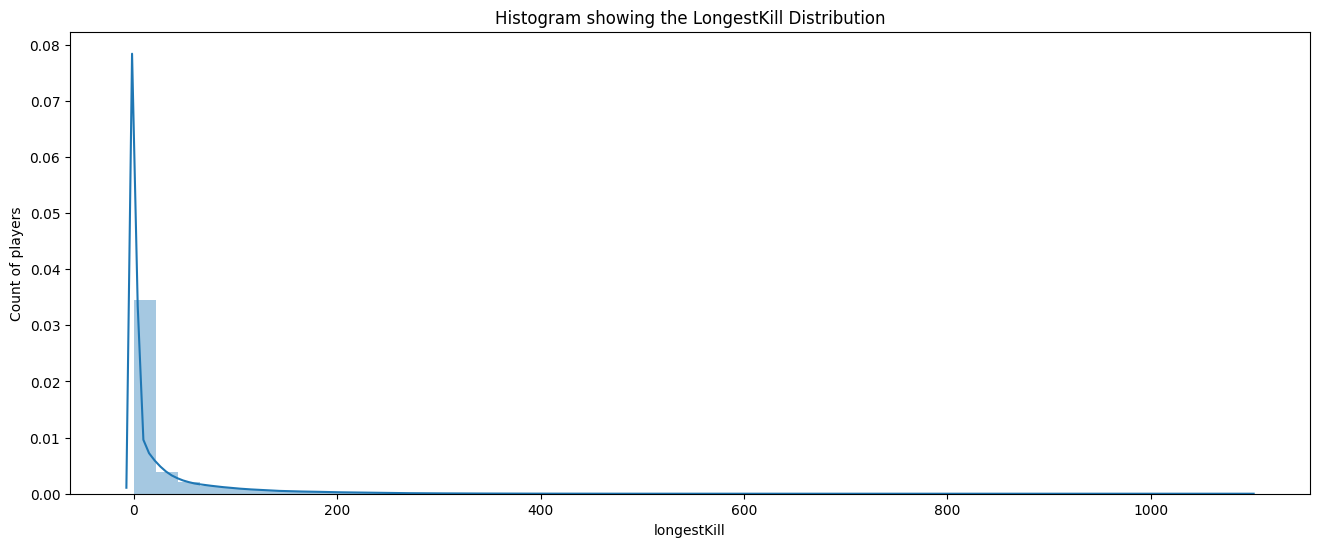

In [24]:
sns.distplot(df['longestKill'], bins = 50).set_title("Histogram showing the LongestKill Distribution")
plt.ylabel("Count of players")
plt.show()

In [25]:
df[df['longestKill']>=700].shape

(407, 33)

In [26]:
df.drop(df[df['longestKill']>=500].index, inplace = True)

# Weapon Change

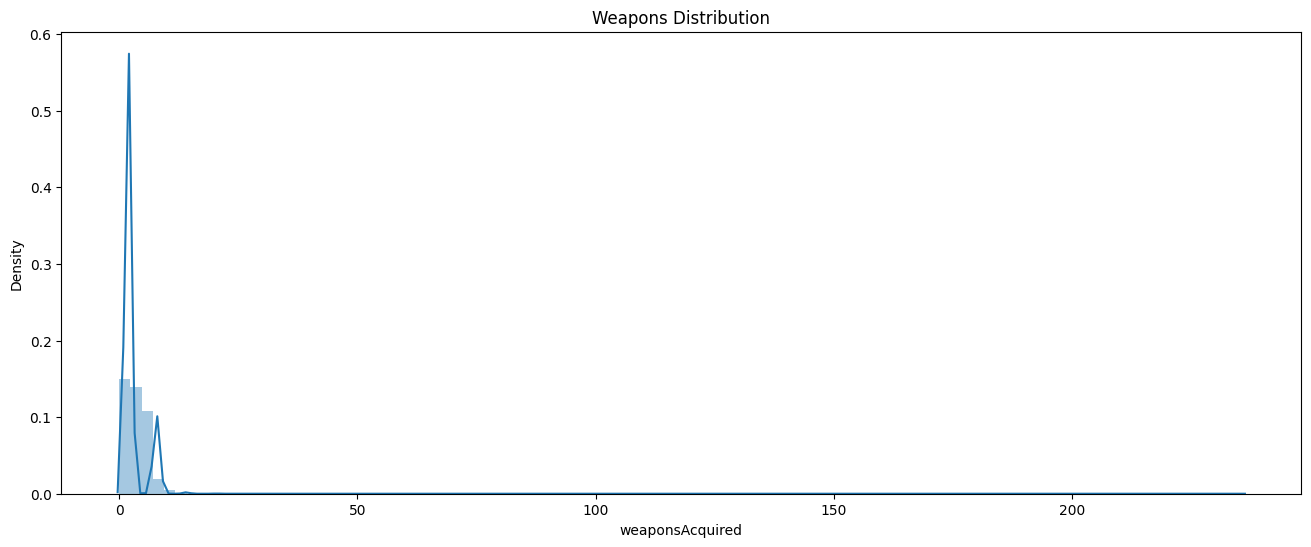

In [27]:
sns.distplot(df['weaponsAcquired'], bins=100).set_title("Weapons Distribution")
plt.show()

In [28]:
df[df['weaponsAcquired']>=15].shape

(6809, 33)

In [29]:
df.drop(df[df['weaponsAcquired']>=15].index, inplace = True)

# <font color="Green"> EDA

In [30]:
df.shape

(4436306, 33)

In [31]:
df.isnull().sum()

Id                    0
groupId               0
matchId               0
assists               0
boosts                0
damageDealt           0
DBNOs                 0
headshotKills         0
heals                 0
killPlace             0
killPoints            0
kills                 0
killStreaks           0
longestKill           0
matchDuration         0
matchType             0
maxPlace              0
numGroups             0
rankPoints            0
revives               0
rideDistance          0
roadKills             0
swimDistance          0
teamKills             0
vehicleDestroys       0
walkDistance          0
weaponsAcquired       0
winPoints             0
winPlacePerc          0
playersJoined         0
TotalDistance         0
killsWithoutMoving    0
headShot_rate         0
dtype: int64

In [32]:
print(df.dtypes)

Id                     object
groupId                object
matchId                object
assists                 int64
boosts                  int64
damageDealt           float64
DBNOs                   int64
headshotKills           int64
heals                   int64
killPlace               int64
killPoints              int64
kills                   int64
killStreaks             int64
longestKill           float64
matchDuration           int64
matchType              object
maxPlace                int64
numGroups               int64
rankPoints              int64
revives                 int64
rideDistance          float64
roadKills               int64
swimDistance          float64
teamKills               int64
vehicleDestroys         int64
walkDistance          float64
weaponsAcquired         int64
winPoints               int64
winPlacePerc          float64
playersJoined           int64
TotalDistance         float64
killsWithoutMoving       bool
headShot_rate         float64
dtype: obj

In [33]:
df_new=df.drop(columns=['matchId','Id','groupId','matchType'])

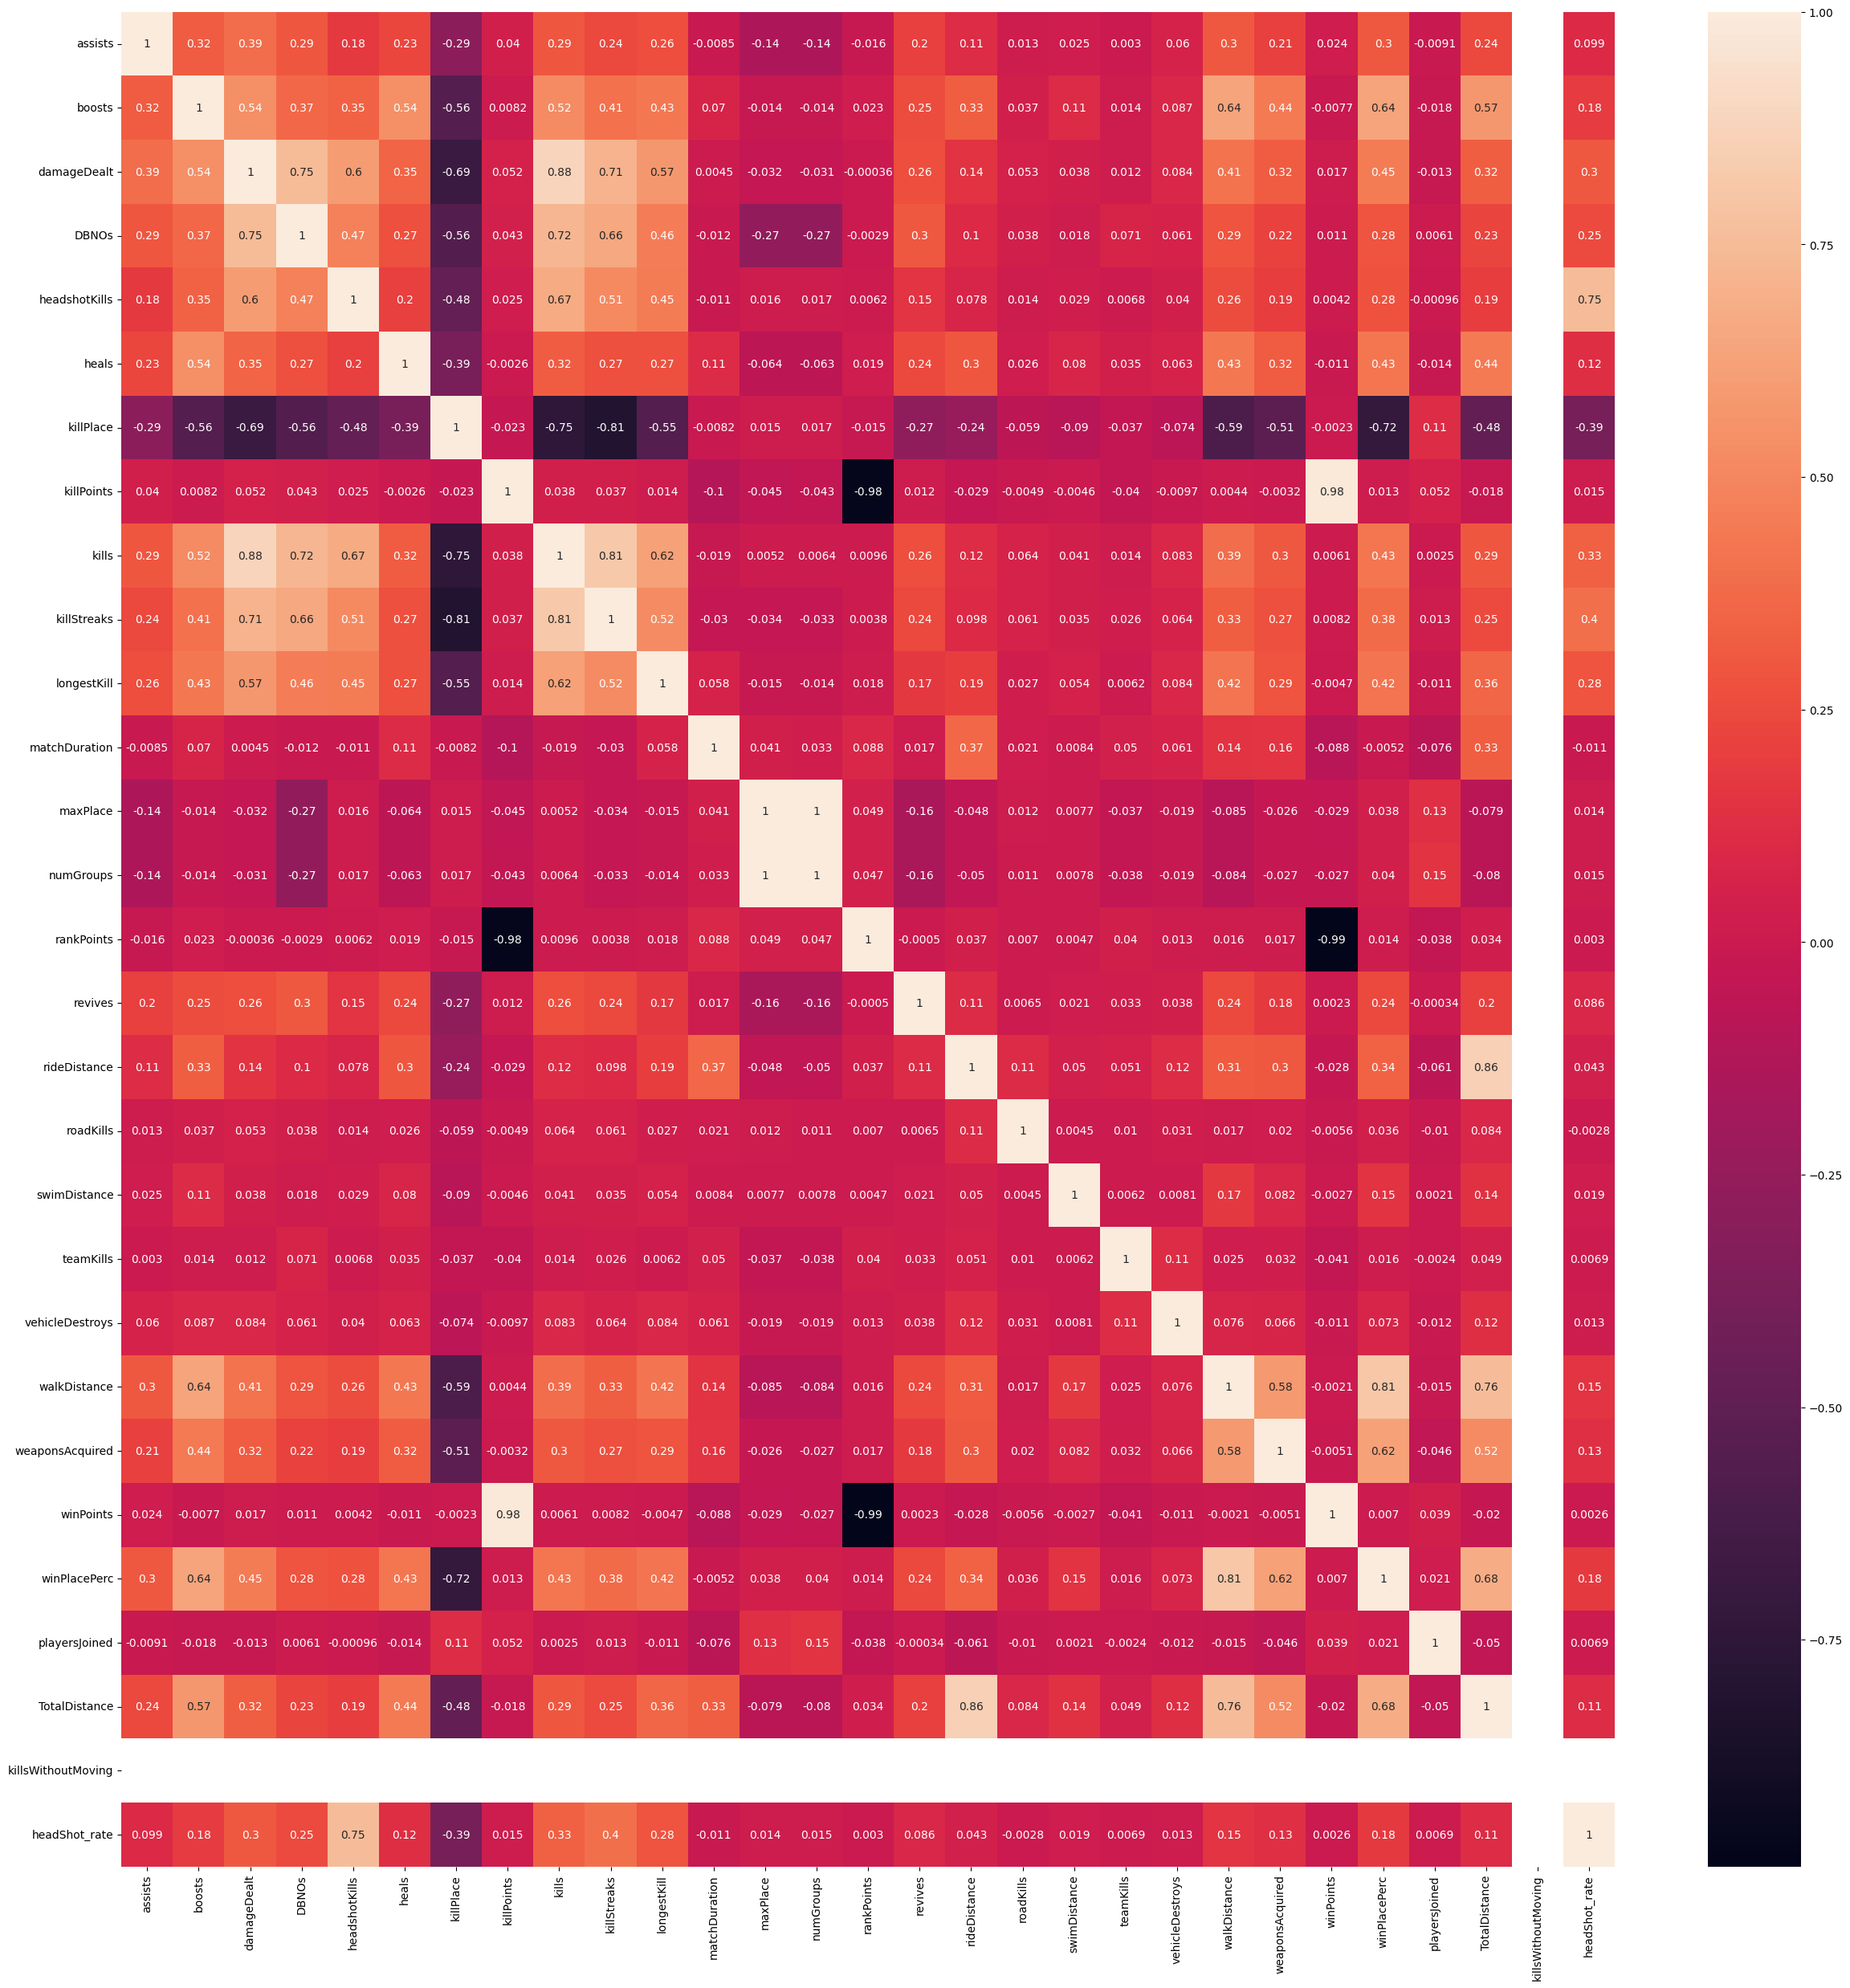

In [34]:
# corretion of parameter with win predication

plt.figure(figsize=[30,30])
sns.heatmap(df_new.corr(), annot = True)
plt.show()
           

# <font color='green'> Feature Engineering <a id="feature">

In [35]:
# if jioned player is less than if effect the kills,damage,maxplace etc
# so we have to normalize the data

normalising_factor = (100 - df['playersJoined']/100)+1

In [36]:
df['killsNorm'] = df['kills'] * normalising_factor
df['damageDealtNorm'] = df['damageDealt'] * normalising_factor
df['maxPlaceNorm'] = df['maxPlace'] * normalising_factor
df['matchDurationNorm'] = df['matchDuration'] * normalising_factor


df['traveldistance'] = df['walkDistance'] + df['swimDistance'] + df['rideDistance']
df['healsnboosts'] = df['heals'] + df['boosts']
df['assist'] = df['assists'] + df['revives']

In [37]:
df.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', 'playersJoined',
       'TotalDistance', 'killsWithoutMoving', 'headShot_rate', 'killsNorm',
       'damageDealtNorm', 'maxPlaceNorm', 'matchDurationNorm',
       'traveldistance', 'healsnboosts', 'assist'],
      dtype='object')

In [38]:
# drop the unimportant columns
data = df.drop(columns = ['Id', 'groupId', 'matchId', 'assists', 'boosts', 'walkDistance', 'swimDistance', 
                          'rideDistance', 'heals', 'revives', 'kills', 'damageDealt', 'maxPlace', 'matchDuration'])

In [39]:
data.head()

,DBNOs,headshotKills,killPlace,killPoints,killStreaks,longestKill,matchType,numGroups,rankPoints,roadKills,...,TotalDistance,killsWithoutMoving,headShot_rate,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,traveldistance,healsnboosts,assist
0,0,0,60,1241,0,0.00,squad-fpp,26,-1,0,...,244.8000,False,0.0,0.00,0.0000,2801.12,130652.24,244.8000,0,0
1,0,0,57,0,0,0.00,squad-fpp,25,1484,0,...,1445.0445,False,0.0,0.00,9155.2323,2602.34,177859.93,1445.0445,0,0
2,0,0,47,0,0,0.00,duo,47,1491,0,...,161.8000,False,0.0,0.00,6801.3600,5001.00,131826.36,161.8000,0,1
3,0,0,75,0,0,0.00,squad-fpp,30,1408,0,...,202.7000,False,0.0,0.00,3292.9610,3102.79,143729.24,202.7000,0,0
4,0,0,45,0,1,58.53,solo-fpp,95,1560,0,...,49.7500,False,0.0,100.03,10003.0000,9702.91,142442.72,49.7500,0,0


# <font color="green"> CatBoost Model <a id="catboost">

# Handlig categorical data

In [40]:
x = data.drop(['winPlacePerc'], axis = 1)
y = data['winPlacePerc']

In [41]:
x=pd.get_dummies(x,columns=['matchType','killsWithoutMoving'])

In [42]:
x.head()

,DBNOs,headshotKills,killPlace,killPoints,killStreaks,longestKill,numGroups,rankPoints,roadKills,teamKills,...,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp,killsWithoutMoving_False
0,0,0,60,1241,0,0.00,26,-1,0,0,...,False,False,False,False,False,False,False,False,True,True
1,0,0,57,0,0,0.00,25,1484,0,0,...,False,False,False,False,False,False,False,False,True,True
2,0,0,47,0,0,0.00,47,1491,0,0,...,False,False,False,False,False,False,False,False,False,True
3,0,0,75,0,0,0.00,30,1408,0,0,...,False,False,False,False,False,False,False,False,True,True
4,0,0,45,0,1,58.53,95,1560,0,0,...,False,False,False,False,False,False,True,False,False,True


In [43]:
x.shape

(4436306, 40)

In [44]:
features=x.columns

# Scaling the data

In [45]:
sc=StandardScaler()
x=pd.DataFrame(sc.fit(x).transform(x))

In [46]:
x.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-0.582937,-0.384018,0.449345,1.172485,-0.765100,-0.459622,-0.732886,-1.212390,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,-0.370797,-0.405071,1.236192,0.0
1,-0.582937,-0.384018,0.340055,-0.804728,-0.765100,-0.459622,-0.775859,0.803564,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,-0.370797,-0.405071,1.236192,0.0
2,-0.582937,-0.384018,-0.024245,-0.804728,-0.765100,-0.459622,0.169557,0.813067,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,-0.370797,-0.405071,-0.808936,0.0
3,-0.582937,-0.384018,0.995795,-0.804728,-0.765100,-0.459622,-0.560992,0.700391,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,-0.370797,-0.405071,1.236192,0.0
4,-0.582937,-0.384018,-0.097105,-0.804728,0.647633,0.727371,2.232284,0.906738,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,2.696896,-0.405071,-0.808936,0.0


# Splitting the data

In [47]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0)

In [48]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(3105414, 40) (3105414,)
(1330892, 40) (1330892,)


# CatBoost Model

In [49]:
import catboost as cb

In [50]:
train_dataset = cb.Pool(x_train, y_train)
test_dataset = cb.Pool(x_test, y_test)

In [51]:
model=cb.CatBoostRegressor(loss_function='RMSE')

In [52]:
# GRID Search

grid = {'iterations': [100, 150], 
       'learning_rate': [0.03, 0.1], 
       'depth': [2, 4, 6, 8]}

model.grid_search(grid, train_dataset)

0:	learn: 0.5482016	test: 0.5479886	best: 0.5479886 (0)	total: 348ms	remaining: 34.4s
1:	learn: 0.5333650	test: 0.5331566	best: 0.5331566 (1)	total: 582ms	remaining: 28.5s
2:	learn: 0.5189826	test: 0.5187815	best: 0.5187815 (2)	total: 813ms	remaining: 26.3s
3:	learn: 0.5050844	test: 0.5048926	best: 0.5048926 (3)	total: 1.04s	remaining: 24.9s
4:	learn: 0.4916276	test: 0.4914432	best: 0.4914432 (4)	total: 1.26s	remaining: 24s
5:	learn: 0.4786251	test: 0.4784449	best: 0.4784449 (5)	total: 1.49s	remaining: 23.3s
6:	learn: 0.4660267	test: 0.4658539	best: 0.4658539 (6)	total: 1.7s	remaining: 22.6s
7:	learn: 0.4538495	test: 0.4536820	best: 0.4536820 (7)	total: 1.93s	remaining: 22.2s
8:	learn: 0.4420341	test: 0.4418693	best: 0.4418693 (8)	total: 2.16s	remaining: 21.9s
9:	learn: 0.4306331	test: 0.4304748	best: 0.4304748 (9)	total: 2.44s	remaining: 21.9s
10:	learn: 0.4195967	test: 0.4194453	best: 0.4194453 (10)	total: 2.67s	remaining: 21.6s
11:	learn: 0.4089243	test: 0.4087765	best: 0.4087765 (1

{'params': {'depth': 8, 'learning_rate': 0.1, 'iterations': 150},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
    

In [53]:
feature_importance_df = pd.DataFrame()
feature_importance_df['features'] = features
feature_importance_df['importance'] = model.feature_importances_

feature_importance_df = feature_importance_df.sort_values(by = ['importance'], ascending=False)

In [54]:
feature_importance_df

,features,importance
2,killPlace,40.804634
14,TotalDistance,12.507865
20,traveldistance,11.786296
16,killsNorm,7.596194
4,killStreaks,7.568429
19,matchDurationNorm,5.355363
13,playersJoined,4.684276
6,numGroups,2.265490
21,healsnboosts,1.830046
5,longestKill,1.805096


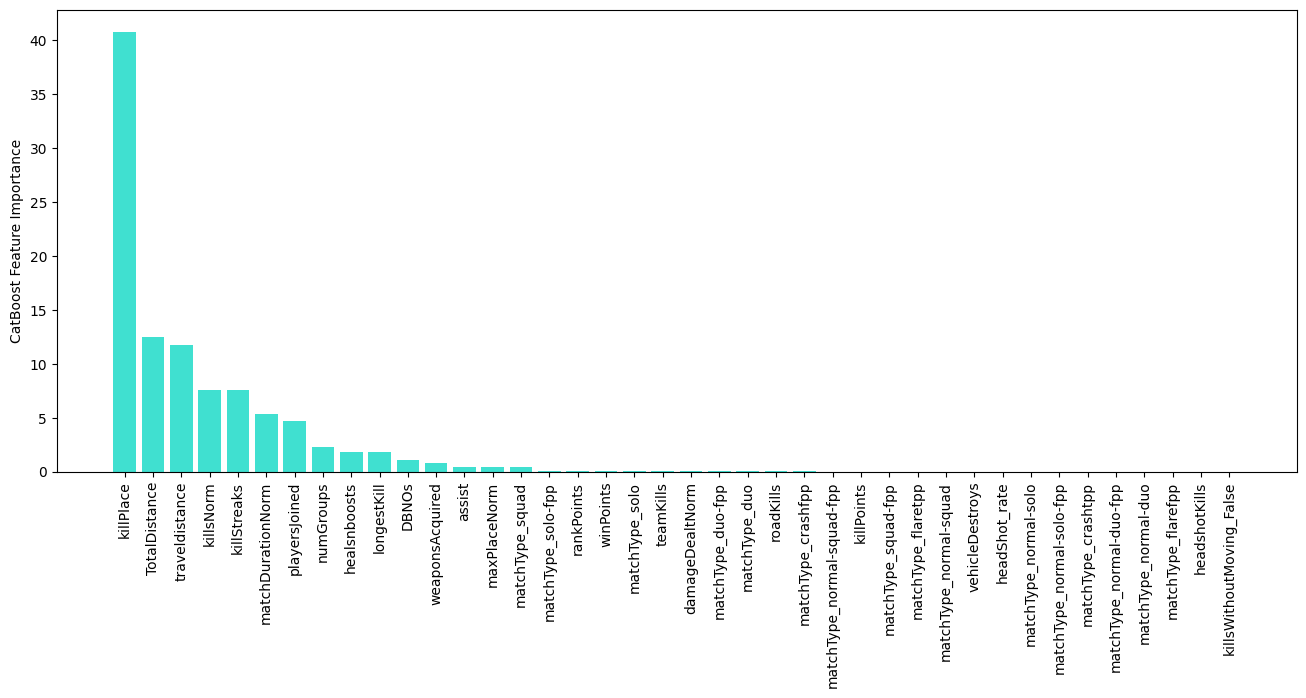

In [55]:
plt.bar(feature_importance_df.features, feature_importance_df.importance, color='turquoise')
plt.ylabel("CatBoost Feature Importance")
plt.xticks(rotation = 90)
plt.show()

# Prediction

In [56]:
pre=model.predict(x_test)

In [57]:
rmse = np.sqrt(mean_squared_error(y_test, pre))
r2 = r2_score(y_test, pre)

print("Testing performance")

print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))

Testing performance
RMSE: 0.08
R2: 0.93
